In [35]:
import pandas as pd
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import cv2
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
import urllib
import numpy as np
import matplotlib.pyplot as plt
import random

# Face Model

In [36]:
# Load pretrained model + processor
face_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [37]:
face_PATH = "./data/fer2013/test/"
emotion_labels = [e for e in os.listdir(face_PATH)]

In [38]:
def create_dataframe(PATH, limit=100, label_name=None, labels=None):
    # Create the database
    rows=[]

    for label in labels:
        current_path = PATH + label
        for (i,file) in enumerate(os.listdir(current_path)):
            file_path = current_path + "/" + file
            img = cv2.imread(file_path)
            if i == limit:
                break
            rows.append({"image":img, label_name:label})

    df = pd.DataFrame(rows)
    # Shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    return df
        

In [39]:
df_faces = create_dataframe(PATH="./data/fer2013/test/", label_name="emotion", labels=emotion_labels)

In [40]:
df_faces.head()

,image,emotion
0,"[[[47, 47, 47], [55, 55, 55], [77, 77, 77], [1...",neutral
1,"[[[252, 252, 252], [255, 255, 255], [249, 249,...",happy
2,"[[[47, 47, 47], [36, 36, 36], [32, 32, 32], [4...",neutral
3,"[[[46, 46, 46], [42, 42, 42], [46, 46, 46], [4...",disgust
4,"[[[23, 23, 23], [0, 0, 0], [0, 0, 0], [2, 2, 2...",neutral


In [41]:
df_faces["image"][0].shape

(48, 48, 3)

In [46]:
def show_image_and_face_prediction(index):
    image = df_faces["image"][index]
    emotion = df_faces["emotion"][index]

    # Convert to PIL (OpenCV loads BGR)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Preprocess
    inputs = face_processor(images=image_pil, return_tensors="pt")

    # Inference
    with torch.no_grad():
        logits = face_model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Print true label
    print(f"True Emotion: {emotion}")
    print("Predictions:")

    # # Print each class with % probability
    # for i, p in enumerate(probs):
    #     label = face_model.config.id2label[i]
    #     print(f"  {label}: {p.item()*100:.2f}%")

    top5_idx = torch.topk(probs, 5).indices
    for idx in top5_idx:
        label = emotion_labels[idx]
        prob = probs[idx].item()*100
        print(f"  {label}: {prob:.2f}%")

    # Display image
    display(image_pil)

True Emotion: fear
Predictions:
  fear: 86.18%
  sad: 11.29%
  angry: 1.17%
  neutral: 1.03%
  surprise: 0.18%


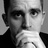

In [63]:
show_image_and_face_prediction(random.randint(0, len(df_faces)-1))

# Scene Model

In [68]:
# Load pretrained weights
scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

# Init ResNet18 for 365 classes
scene_model = models.resnet18(num_classes=365)
scene_model.fc = nn.Linear(scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
scene_model.load_state_dict(scene_state_dict)
scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [69]:
scene_PATH = "./data/places365/val/"
scene_labels = [e for e in os.listdir(scene_PATH)]

In [70]:
df_scenes = create_dataframe(PATH="./data/places365/val/",limit=5, label_name="scene", labels=scene_labels)

In [71]:
df_scenes.head()

,image,scene
0,"[[[214, 204, 194], [214, 204, 194], [214, 204,...",runway
1,"[[[244, 250, 249], [244, 250, 249], [244, 250,...",railroad_track
2,"[[[85, 106, 133], [98, 119, 146], [115, 137, 1...",galley
3,"[[[168, 101, 62], [169, 102, 63], [170, 103, 6...",wind_farm
4,"[[[251, 255, 255], [251, 255, 255], [253, 255,...",veterinarians_office


In [72]:
df_scenes["image"][0].shape

(256, 256, 3)

In [73]:
def show_image_and_scene_prediction(index):
    image = df_scenes["image"][index]
    scene = df_scenes["scene"][index]

    # Convert to PIL (OpenCV loads BGR)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    input_tensor = scene_tf(image_pil).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        logits = scene_model(input_tensor)
        probs = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Print true label
    print(f"True Scene: {scene}")
    print("Predictions:")

    top5_idx = torch.topk(probs, 5).indices
    for idx in top5_idx:
        label = scene_labels[idx]
        prob = probs[idx].item()*100
        print(f"  {label}: {prob:.2f}%")

    # Display image
    display(image_pil)

True Scene: fountain
Predictions:
  fountain: 79.80%
  museum-outdoor: 6.98%
  palace: 3.28%
  library-outdoor: 1.66%
  plaza: 1.35%


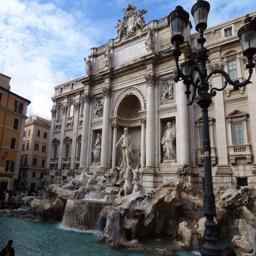

In [83]:
show_image_and_scene_prediction(random.randint(0, len(df_scenes)-1))